# Python Package for USDA-ARS SCINet GeoCDL

## Overview
This tutorial covers the python package `pygcdl` for the SCINet Geospatial Common 
Data Library (GeoCDL), a community project from the 
[Geospatial Research Working Group](https://scinet.usda.gov/working-groups/geospatial) 
to reduce the time and effort to access commonly used geospatial datasets. This tutorial is based on the vignette for the R counterpart of pygcdl, rgeocdl. We have
collected several large gridded data products to store on Ceres and created a 
REST API for SCINet users to request the spatiotemporal subsets of those data 
that they need. The geospatial processing to create those subsets executes on 
Ceres and a service node has been setup to serve the API. 

This python package is a user-friendly interface to pass along user requests to the 
core GeoCDL API from the compute nodes. That is, the python package does not perform 
the geospatial processing itself. A major benefit of using this python package is that 
it was designed to integrate into a user's geospatial data processing workflow in 
R. For example, a user storing their study area boundary definition as a `geopandas.GeoDataFrame` 
object can pass along that object to this package's functions and the package will
do the necessary formatting of the data to make it compatible with GeoCDL. 

The workflows we will cover include uploading a shapefile of an LTAR site, requesting data from two datasets clipped to the boundary of the LTAR site with equivalent resolutions and CRSs, and visualizing the resulting 
maps. We also show how to extract point level information from a gridded layer.

This tutorial assumes you are running this notebook in JupyterLab on 
Ceres. The easiest way to do that is with 
[Open OnDemand](http://ceres-ood.scinet.usda.gov/). As of this writing, the GeoCDL 
is only available on Ceres and not Atlas. 

If you have any questions, problems, or requests related to the python interface, please 
use the issue tracker on our GitHub repository: 
[https://github.com/USDA-SCINet/rgeocdl](https://github.com/USDA-SCINet/pygcdl). 

## Nomenclature

* <b>GeoCDL:</b> Geospatial Common Data Library, a collection of commonly used raster 
  datasets accessible from an API running on SCINet's Ceres cluster
* <b>Raster:</b> A geospatial datatype where data is stored as a grid of regularly sized pixels. Geospatial rasters contain geospatial metadata, which maps each pixel of the raster to a geospatial location on the Earth's surface. Examples of geospatial raster file types include: geotiff (.tif), and netCDF (.nc).
* <b>Vector:</b> A geospatial datatype where data is stored as a collection of points, lines, or polygons. Each coordinate maps to a location on Earth's surface. Examples of geospatial vector file types include: geojson (.geojson), and shapefiles (.shp). 
* <b>CRS:</b> Coordinate Reference System, also known as a spatial reference system. A
  system for defining geospatial coordinates.

## Data Details

###### Dataset: MODIS NDVI
* Link: [https://doi.org/10.3334/ORNLDAAC/1299](https://doi.org/10.3334/ORNLDAAC/1299)
* Details: This data set provides Moderate Resolution Imaging Spectroradiometer 
  (MODIS) normalized difference vegetation index (NDVI) data, smoothed and gap-filled, 
  for the conterminous US for the period 2000-01-01 through 2015-12-31. The data 
  were generated using the NASA Stennis Time Series Product Tool (TSPT) to generate 
  NDVI data streams from the Terra satellite (MODIS MOD13Q1 product) and Aqua 
  satellite (MODIS MYD13Q1 product) instruments. TSPT produces NDVI data that 
  are less affected by clouds and bad pixels.

###### Dataset: PRISM
* Link: [https://prism.oregonstate.edu/](https://prism.oregonstate.edu/)
* Details: The PRISM Climate Group gathers climate observations from a 
  wide range of monitoring networks, applies sophisticated quality control 
  measures, and develops spatial climate datasets to reveal short- and long-term 
  climate patterns. The resulting datasets incorporate a variety of modeling 
  techniques and are available at multiple spatial/temporal resolutions, covering 
  the period from 1895 to the present.


## Primary Libraries

| Name | Description | Link |
|:--|:--|:--|
| pygcdl | Python interface for SCINet GeoCDL API | https://github.com/USDA-SCINet/pygcdl |
| geopandas | Geospatial vector data for python | https://geopandas.org/en/stable/|
| requests | 


### Tutorial Steps:
0. Import Libraries
1. Specify area and dates of interest 
2. Select datasets and their variables
3. Download the data
4. Visualize the results


#### Part 0: Import Libraries

In [1]:
# Import the necessary packages

import pygcdl
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
import requests as r

In [2]:
# Create the pygcdl object in order to interact with the pygcdl package
pygcdl_obj = pygcdl.PyGeoCDL()

#### Part 1: Specify area and dates of interest 

Here, we specify the spatial extend of our requests. We can request either polygon-based or point-based subsets. When we request a subset, we can specify the spatial extent in one of these three ways:

- <b>GUID: </b> Users can use the `upload_geometry()` function to upload a file or geopandas GeoDataFrame object, receive a Geometry Upload Identifier (GUID), and use that GUID for subsequent data requests.
- <b>Clip: </b> Users can specify the coordinates of a bounding box (polygon data only).
- <b>GeoDataFrame: </b> Users can build a geopandas.GeoDataFrame object and use it in requests directly, without uploading it in advance.

For this tutorial, we will upload a shapefile containing polygon data that represents the Jornada Experimental Range in southern New Mexico.

In [3]:
# First, download the shapefile from AgCROS
url = "https://services1.arcgis.com/SyUSN23vOoYdfLC8/arcgis/rest/services/LTAR_Base/FeatureServer/1/query?where=acronym='JER'&f=pgeojson"
response = r.get(url)
filename = "jer_bounds_sf.geojson"
with open(filename, mode="wb") as file:
    file.write(response.content) # save file locally

We wish to download data in the CRS EPSG:32613, so we load our file into geopandas, transform the crs, and overwrite the file. The EPSG:32613 CRS is a projected CRS that covers New Mexico in its area of use. You can learn more about this crs [here](https://epsg.io/32613).

In [4]:
bounds = gpd.read_file(filename) # load file into geopandas
bounds = bounds.to_crs("EPSG:32613") # transform geopandas dataframe to desired CRS
bounds.to_file(filename) # overwrite file location with transformed data

<Axes: >

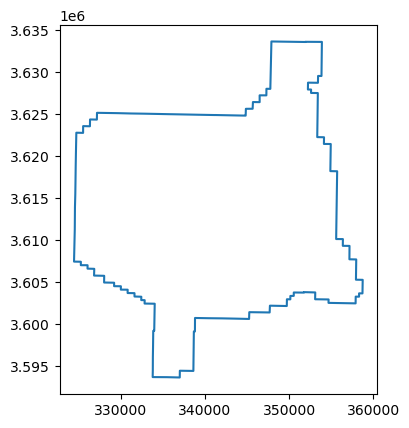

In [5]:
# Visualize downloaded boundary
bounds.boundary.plot()

We can see from the plotted map that the site is an irregular shape. For cases like this where the geometry is defined by many points, it is easiest to provide GeoCDL with a file containing the geometry definition, instead of uploading clipping coordinates. We can upload this geometry to GeoCDL using the `upload_geometry` function which returns a unique geometry upload identifier (GUID) that we will use later in our subset request. This stand-alone upload step is optional, but recommended if you are likely to submit multiple subset requests with the same geometry so that it is uploaded just once. You could alternatively use the geopandas GeoDataFrame object directly in requests, but if we upload the geometry file, then we can re-use the GUID.

Here, we upload our file by calling `upload_geometry()` on our `pygcdl_obj` object.

In [6]:
guid = pygcdl_obj.upload_geometry(bounds)
print(guid)

ec75e5e9-eb85-4cee-b0dc-ab59fa78377a


To finish the spatial component of our subset request, we will define our target spatial resolution and a resampling method. By indicating a target spatial resolution along with our geometry, we are telling GeoCDL that we want a spatially-harmonized 'datacube', which means that each requested data layer has the same CRS, spatial resolution, and spatial extent. 

Unless we specify otherwise, the target CRS in this case is that of our geometry. Resampling is the process by which the GCDL calculates pixel values when the cell grid changes, like when we change the resolution or CRS. This calculation is performed by rasterio, and you can find the full list of reprojection methods [here](https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling). The default resampling method is to take the nearest pixel. Here, we choose the "bilinear" method, which you can learn more about [here](https://gisgeography.com/bilinear-interpolation-resampling/).

Our CRS, EPSG:32613, is in units of meters. Therefore, our spatial resolution is in units of meters. Here, we specify that we want each pixel to represent an area of 1000 by 1000 meters.

In [7]:
spat_res = 1000 # in units of meters
resample_method = "bilinear"

Next, we specify our temporal data. The GeoCDL accepts multiple temporal range formats so that many different user 
needs can be met. In this example, we are interested in July-August 2008. One way to specify that is with the years and months together as `'2008-07:2008-08'` or separately as below. By specifying years and months, we are letting GeoCDL know that we are interested in monthly data. If we only specify years, then it will infer we want annual data and if we also specifies days, then it will infer we want daily data. However, users can also request a combination of temporal grains by specifying a 'grain method'. In this example, we are also interested in both annual and daily data available within July-August 2008, so we will indicate the 'any' grain method.

In [8]:
years = "2008"
months = "7:8"
grain_method = "any"

#### Part 2: Select datasets and their variables


We can use the `list_datasets()` function to list all of the datasets that are available in the Geospatial Common Data Library.

In [9]:
pygcdl_obj.list_datasets()

{'DaymetV4': 'Daymet Version 4',
 'GTOPO30': 'Global 30 Arc-Second Elevation',
 'MODIS_NDVI': 'MODIS NDVI Data, Smoothed and Gap-filled, for the Conterminous US: 2000-2015',
 'NASS_CDL': 'NASS Cropland Data Layer',
 'NLCD': 'National Land Cover Database',
 'PRISM': 'PRISM',
 'RAPV3': 'Rangeland Analysis Platform Version 3',
 'SMAP-HB1km': 'SMAP HydroBlocks - 1 km',
 'Soilgrids250mV2': 'SoilGrids — global gridded soil information',
 'VIP': 'Vegetation Index and Phenology (VIP) Vegetation Indices Daily Global 0.05Deg CMG V004'}

We can use the `get_dataset_info()` function to learn more about one specific dataset.

In [10]:
# Get information about the MODIS_NDVI dataset
pygcdl_obj.get_dataset_info("MODIS_NDVI")

{'name': 'MODIS NDVI Data, Smoothed and Gap-filled, for the Conterminous US: 2000-2015',
 'id': 'MODIS_NDVI',
 'url': 'https://doi.org/10.3334/ORNLDAAC/1299',
 'description': 'This data set provides Moderate Resolution Imaging Spectroradiometer (MODIS) normalized difference vegetation index (NDVI) data, smoothed and gap-filled, for the conterminous US for the period 2000-01-01 through 2015-12-31. The data were generated using the NASA Stennis Time Series Product Tool (TSPT) to generate NDVI data streams from the Terra satellite (MODIS MOD13Q1 product) and Aqua satellite (MODIS MYD13Q1 product) instruments. TSPT produces NDVI data that are less affected by clouds and bad pixels.',
 'provider_name': 'ORNL DAAC',
 'provider_url': 'https://daac.ornl.gov',
 'grid_size': 250,
 'grid_unit': 'meters',
 'vars': {'NDVI': 'Normalized Difference Vegetation Index'},
 'temporal_resolution': {'year': None, 'month': None, 'day': '8 days'},
 'date_ranges': {'year': [None, None],
  'month': [None, None]

In [11]:
# Get information about the PRISM dataset
pygcdl_obj.get_dataset_info("PRISM")

{'name': 'PRISM',
 'id': 'PRISM',
 'url': 'https://prism.oregonstate.edu/',
 'description': 'The PRISM Climate Group gathers climate observations from a wide range of monitoring networks, applies sophisticated quality control measures, and develops spatial climate datasets to reveal short- and long-term climate patterns. The resulting datasets incorporate a variety of modeling techniques and are available at multiple spatial/temporal resolutions, covering the period from 1895 to the present.',
 'provider_name': 'PRISM Climate Group, Oregon State University',
 'provider_url': 'https://prism.oregonstate.edu/',
 'grid_size': 0.041666666666666664,
 'grid_unit': 'degrees',
 'vars': {'ppt': 'total precipitation (rain+melted snow)',
  'tmean': 'mean temperature (mean of tmin and tmax)',
  'tmin': 'minimum temperature',
  'tmax': 'maximum temperature',
  'tdmean': 'mean dew point temperature',
  'vpdmin': 'minimum vapor pressure deficit',
  'vpdmax': 'maximum vapor pressure deficit'},
 'tempor

Next, we will specify the datasets and variables we wish to use with a pandas dataframe. Here we specify that we want the ppt variable from the PRISM dataset, and the NDVI variable from the MODIS_NDVI dataset. We can format our dataset and variable specifications as a pandas dataframe, a numpy array, a matrix, or a dict. Here, we format our specifications as a pandas dataframe.

In [12]:
dsvars = pd.DataFrame(
    [["PRISM", "ppt"], ["MODIS_NDVI", "NDVI"]], 
    columns=["dataset", "variable"])
print(dsvars)

      dataset variable
0       PRISM      ppt
1  MODIS_NDVI     NDVI


#### Part 3: Download the data

First, we create a directory where we would like our data to download to.

In [13]:
output_path = Path("output")
if not output_path.is_dir():
    output_path.mkdir()

Up until now, we have been primarily saving our request specifications as variables. We will now pass each of those variables to the GeoCDL and download our subset using the `download_polygon_subset` function. GeoCDL returns a zipped folder of results and `pygcdl` unzips it for you. `download_polygon_subset` returns the filenames in that folder. We have here two monthly PRISM layers, XX daily MODIS NDVI layers (every 8 days), plus a metadata file that lists metadata related to the geospatial datasets as well as the GeoCDL request itself. The raster layer files are GeoTIFFs with the dataset, variable, and date indicated in the  filename.

In [16]:
output_files = pygcdl_obj.download_polygon_subset(
    dsvars=dsvars, 
    years=years,
    months=months,
    grain_method=grain_method,
    t_geom=guid,
    dsn=output_path,
)

http://127.0.0.1:8000/subset_polygon?datasets=PRISM%3Appt%3BMODIS_NDVI%3ANDVI&geom_guid=ec75e5e9-eb85-4cee-b0dc-ab59fa78377a&resample_method=nearest&years=2008&months=7%3A8&grain_method=any&validate_method=strict&output_format=geotiff
Written file:  output\gcdl_subset_240430_094136_1.zip
Files in downloaded zipfile:  ['metadata.json', 'PRISM_ppt_2008-07.tif', 'PRISM_ppt_2008-08.tif', 'MODIS_NDVI_NDVI_2008-07-07.tif', 'MODIS_NDVI_NDVI_2008-07-15.tif', 'MODIS_NDVI_NDVI_2008-07-23.tif', 'MODIS_NDVI_NDVI_2008-07-31.tif', 'MODIS_NDVI_NDVI_2008-08-08.tif', 'MODIS_NDVI_NDVI_2008-08-16.tif', 'MODIS_NDVI_NDVI_2008-08-24.tif']


In [17]:
output_files

['metadata.json',
 'PRISM_ppt_2008-07.tif',
 'PRISM_ppt_2008-08.tif',
 'MODIS_NDVI_NDVI_2008-07-07.tif',
 'MODIS_NDVI_NDVI_2008-07-15.tif',
 'MODIS_NDVI_NDVI_2008-07-23.tif',
 'MODIS_NDVI_NDVI_2008-07-31.tif',
 'MODIS_NDVI_NDVI_2008-08-08.tif',
 'MODIS_NDVI_NDVI_2008-08-16.tif',
 'MODIS_NDVI_NDVI_2008-08-24.tif']

#### Part 4: Visualize the results